# <center>Music Genre Classification</center>
## <center>Progetto per l'esame di Programmazione di applicazioni di Data Intensive (2023)</center>
### <center>Rubboli Petroselli Gabriele</center>

# Descrizione del problema e analisi esplorativa

Il progetto ha lo scopo di creare un modello in grado di classificare come meglio si può una canzone secondo un genere musicale, avendone in possesso dati di diverso tipo quali chiave musicale, tempo, popolarità, ecc...

### Librerie

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pickle
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

## Caricamento dati e Preprocessing

Iniziamo importando il file csv di training contenente tutti i dati, se presente.

In [4]:
import os.path
file = "train.csv"
if not os.path.exists(file):
    print("Missing dataset, retrieve it from kaggle")

songs = pd.read_csv(file)

stampiamone la testa e la coda per farci un idea del contenuto del dataset.

In [5]:
songs.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [6]:
songs.tail()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
17991,Green-House,Find Home,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.99300,0.824000,0.0984,0.177,171.587,193450.0,3,6
17992,Micatone,All Gone,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.85800,0.000016,0.0705,0.335,73.016,257067.0,4,2
17993,Smash Hit Combo,Peine perdue,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.00003,0.000136,0.6660,0.262,105.000,216222.0,4,8
17994,Beherit,Salomon's Gate,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.00129,0.916000,0.2560,0.355,131.363,219693.0,4,8
17995,The Raconteurs,Broken Boy Soldier,43.0,0.400,0.853,4.0,-5.320,0,0.0591,0.00604,0.212000,0.3340,0.377,138.102,182227.0,4,10


Per ogni colonna visualizziamo il tipo di dato in questione, il numero di valori non nulli e la memoria che occupa.
Questi dati possono esserci utili per comprendere l'integrità e la qualità dei dati che abbiamo a disposizione.

In [7]:
songs.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

Possiamo vedere come le feature Popularity, key e instrumentalness presentino valori nulli.

## Significato delle Feature

Di seguito riportiamo il significato delle feature che abbiamo a disposizione per ogni traccia in analisi:

- `Artist Name`: il nome dell' autore della canzone.

- `Track Name`: il titolo della canzone.

- `Popularity`: un indice numerico che indica la popolarità ottenuta da un pezzo.

- `danceability`: un valore da 0 a 1 che indica quanto una canzone sia "ballabile" considerando vari fattori come ritmica, tempo, ecc...

- `energy`: un valore da 0 a 1 che rappresenta l' intensità e l' energia di un pezzo.

- `key`: indica la chiave musicale con un valore che va da 1 a 11 seguendo la scala cromatica. il valore 1 corrisponde a DO# poiché nel dataset non sono considerati pezzi in DO.

- `loudness`: indica il "volume" di un pezzo in db.

- `mode`: indica se il pezzo è in chiave maggiore (1) o minore (0).

- `speechiness`: valore da 0 a 1 che indica la quantità di parole in un pezzo. Avvicinandosi allo zero indica un pezzo con poche parole e tanta musica.

- `acousticness`: valore da 0 a 1 che indica quanto una canzone sia acustica (totalmente acustica = 1).

- `instrumentalness`: valore da 0 a 1 che indica la presenza di voce in un pezzo. Avvicinandosi a 1 abbiamo un pezzo molto strumentale.

- `liveness`: valore che indica la probabilità che un pezzo sia stato reistrato live davanti a un pubblico.

- `valence`: misura da 0 a 1 che crescendo indica un pezzo dalle vibe più positive, allegro.

- `tempo`: indica il tempo del pezzo in Bpm (battiti per minuto).

- `duration_in min/ms`: indica la durata del pezzo.

- `time_signature`: indica quanti battiti ci sono in un misura (3/4, 4/4) in un determinato pezzo.

- `Class`: la variabile che dovremo determinare date le altre, ovvero il genere musicale di un pezzo.

Attraverso la funzione describe otteniamo vari dati relativi alle feature numeriche del dataset.

In [8]:
songs.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


Stampiamo i valori unici per ogni colonna.

In [9]:
for col in songs.columns:
    print(col + ": " + str(songs[col].nunique()))

Artist Name: 9149
Track Name: 15129
Popularity: 100
danceability: 909
energy: 1208
key: 11
loudness: 9002
mode: 2
speechiness: 1194
acousticness: 3930
instrumentalness: 4253
liveness: 1459
valence: 1320
tempo: 13562
duration_in min/ms: 14121
time_signature: 4
Class: 11


Andiamo a calcolare la moda per Popularity e key, e la mediana per instrumentalness.
Poi riempiamo i "buchi" nulli con questi valori fissi, in modo da avere una stima completa.

In [10]:
mode = songs["Popularity"].mode()
songs["Popularity"] = songs["Popularity"].fillna(mode[0])
mode = songs["key"].mode()
songs["key"] = songs["key"].fillna(mode[0])
median = songs["instrumentalness"].median()
songs["instrumentalness"] =  songs["instrumentalness"].fillna(median)

Notiamo ora con questa istruzione che non sono più presenti valori nulli nel dataset.

In [11]:
songs.isnull().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

Nel file fornito submission.csv possiamo vedere i nomi dei generi musicali associati ai numeri presenti nel dataset.

In [12]:
nomi_generi = pd.read_csv("submission.csv")
nomi_generi.head(11)

,Acoustic/Folk_0,Alt_Music_1,Blues_2,Bollywood_3,Country_4,HipHop_5,Indie Alt_6,Instrumental_7,Metal_8,Pop_9,Rock_10
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,1,0


Possiamo ora creare una mappa che associ a ogni valore numerico della colonna Class del dataset (da 0 a 10) a un nome di genere musicale.

In [13]:
mappa_generi = {0: "Acoustic/Folk", 1: "Alt_Music", 2: "Blues", 3: "Bollywood", 4: "Country", 5: "HipHop",
               6: "Indie_Alt", 7: "Instrumental", 8: "Metal", 9: "Pop", 10: "Rock"}

Andiamo a posizionare la colonna dei generi come terza per comodità e sostituiamo i numeri direttamente coi nomi dei generi nel dataset.

In [14]:
songs = songs[['Artist Name', 'Track Name', 'Class'] +
        [col for col in songs.columns if col not in ['Artist Name', 'Track Name', 'Class']]]
songs['Class'] = songs['Class'].replace(mappa_generi)
songs.head()

,Artist Name,Track Name,Class,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
0,Bruno Mars,That's What I Like (feat. Gucci Mane),HipHop,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,0.003910,0.0849,0.8990,134.071,234596.0,4
1,Boston,Hitch a Ride,Rock,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4
2,The Raincoats,No Side to Fall In,Indie_Alt,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4
3,Deno,Lingo (feat. J.I & Chunkz),HipHop,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,0.003910,0.1220,0.5690,107.033,173968.0,4
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,Rock,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4


Creiamo un grafico a torta e uno a barre per visualizzare la distribuzione dei generi musiacali.

In [15]:
songs["Class"].value_counts()

Class
Rock             4949
Indie_Alt        2587
Pop              2524
Metal            1854
HipHop           1447
Alt_Music        1373
Blues            1272
Acoustic/Folk     625
Instrumental      576
Bollywood         402
Country           387
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribuzione dei generi musicali')

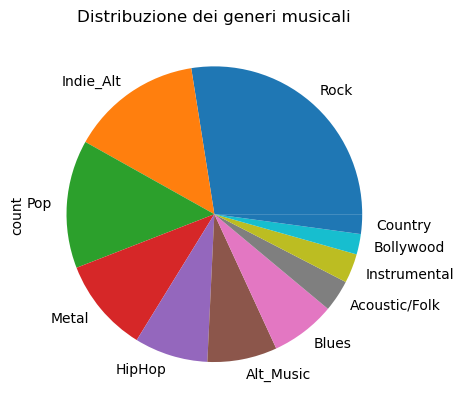

In [16]:
pie_plot = songs["Class"].value_counts().plot.pie()
plt.title('Distribuzione dei generi musicali')

Text(0.5, 1.0, 'Distribuzione dei generi musicali (Grafico a Barre)')

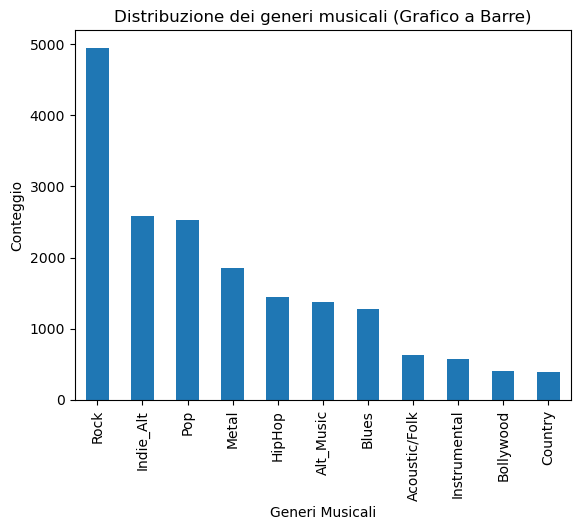

In [17]:
songs["Class"].value_counts().plot.bar()

plt.xlabel('Generi Musicali')
plt.ylabel('Conteggio')
plt.title('Distribuzione dei generi musicali (Grafico a Barre)')

Da questi grafici possiamo vedere come i generi musicali più presenti siano senza dubbio il Rock, il Pop e l'Alt.

Analizziamo ora alcune correlazioni tra variabili predittive e la classe da predire.

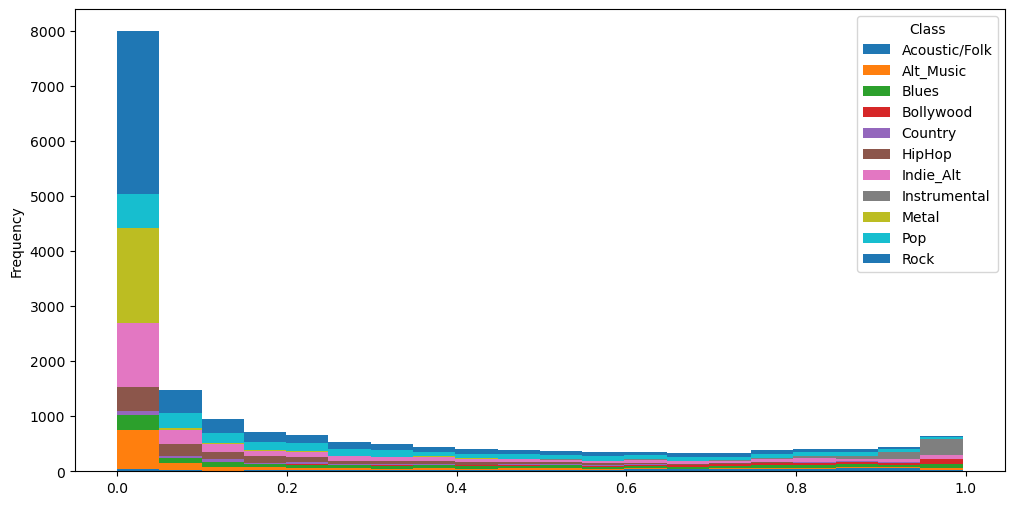

In [18]:
songs.pivot(columns="Class")["acousticness"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

Da questo grafico possiamo notare come un maggiore valore di Acousticness ci porti verso i generi Instrumental, Bollywood e anche Rock e Pop talvolta.
Ad esempio è improbabile che una canzone con un alto livello di Acousticness appartenga al genere Rap/HipHop.

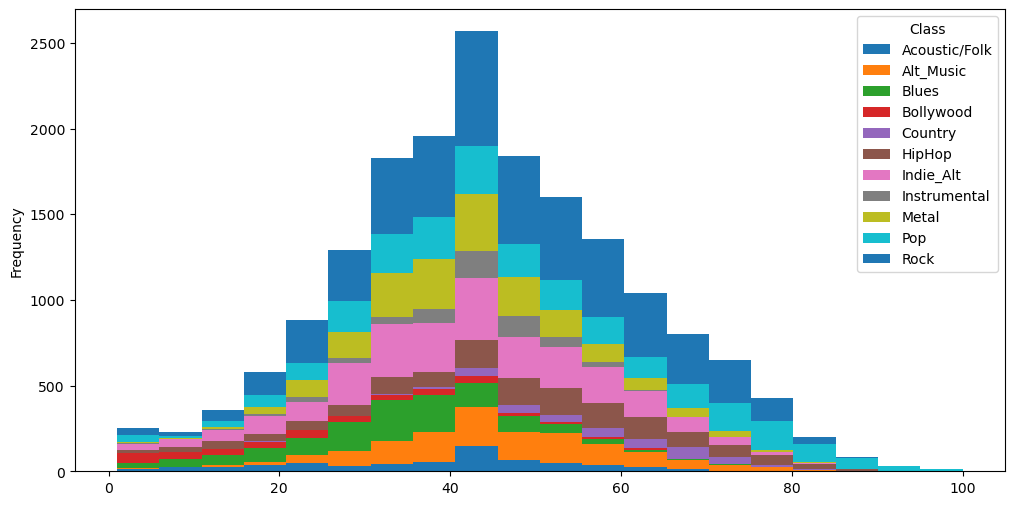

In [19]:
songs.pivot(columns="Class")["Popularity"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

Da quest altro grafico possiamo vedere come un alto valore di Popularity ci indichi molto probabilmente un pezzo Rock o Pop.

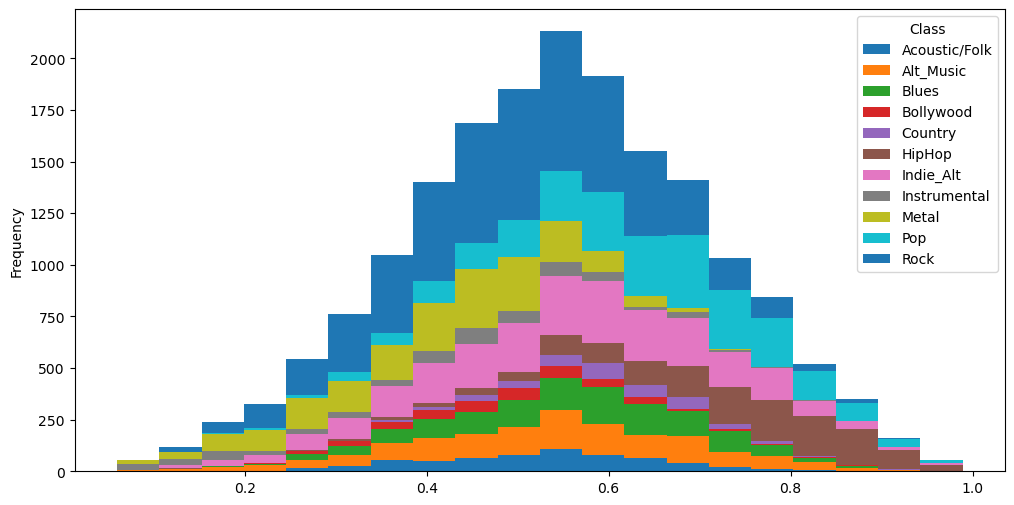

In [20]:
songs.pivot(columns="Class")["danceability"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

Qui invece possiamo notare come aumenti progressivamente la probabilità di trovarci di fronte a un pezzo HipHop man mano che aumentiamo il valore di Danceability.

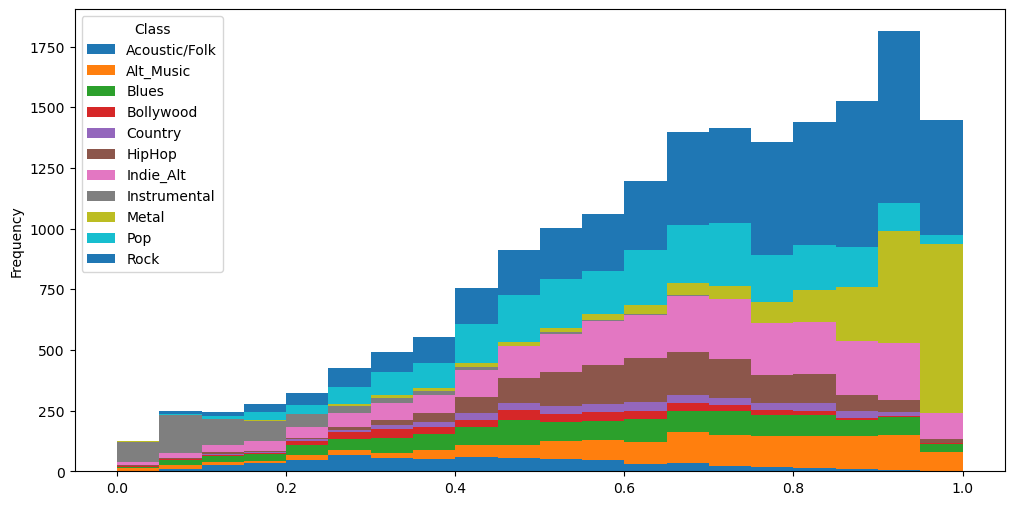

In [21]:
songs.pivot(columns="Class")["energy"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

Questo grafico ci suggerisce come il genere Instrumental corrisponda a un bassissimo livello di Energy, al contrario se ci troviamo di fronte a un valore di Energy vicino a 1.0, abbiamo un alta probabilità di un pezzo appartenente ai generi Rock, Pop o Metal.

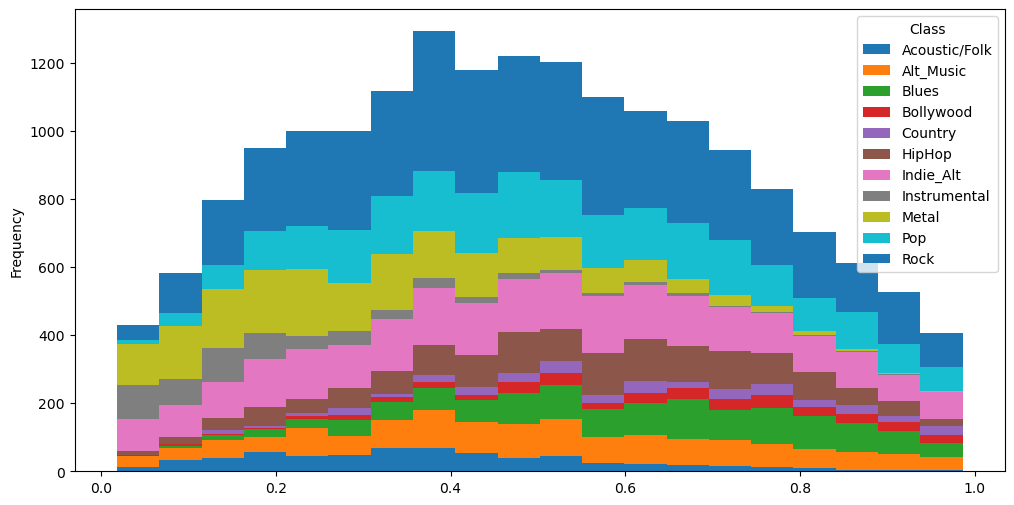

In [22]:
songs.pivot(columns="Class")["valence"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

Da questo grafico possiamo notare come i generi Metal, Folk e Alt tendano ad atmosfere più cupe/tristi, mentre ad esempio l' HipHop tende a una maggiore spensieratezza.

Dividiamo per comodità i valori di Popularity in 10 intervalli e gli assegnamo etichette numeriche.
Poi sostituiamo il tipo di dato attuale di key, mode, time_signature e Popularity con il tipo categorico, poiché si trattano di dati categorici.

In [23]:
songs["Popularity"] = pd.cut(songs["Popularity"], bins=10, labels=False)
songs[["key", "mode", "time_signature", "Popularity"]] = songs[["key", "mode", "time_signature", "Popularity"]].astype("category")
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Artist Name         17996 non-null  object  
 1   Track Name          17996 non-null  object  
 2   Class               17996 non-null  object  
 3   Popularity          17996 non-null  category
 4   danceability        17996 non-null  float64 
 5   energy              17996 non-null  float64 
 6   key                 17996 non-null  category
 7   loudness            17996 non-null  float64 
 8   mode                17996 non-null  category
 9   speechiness         17996 non-null  float64 
 10  acousticness        17996 non-null  float64 
 11  instrumentalness    17996 non-null  float64 
 12  liveness            17996 non-null  float64 
 13  valence             17996 non-null  float64 
 14  tempo               17996 non-null  float64 
 15  duration_in min/ms  17996 non-null  

# Preprocessing dei dati

Effettuiamo una trasformazione dei dati in modo che siano pronti per essere elaborati dagli algoritmi di learning.

Creiamo un vettore X contenente i valori della classe da predire e un dataset Y equivalente a quello originale, ma senza ovviamente la classe da predire, e senza il nome dell'artista e della canzone, poiché questi ultimi dati non ci aiutano in nessun modo a capire il genere di una determinata canzone nel nostro caso.
Andiamo poi a calcolare il numero di colonne che contengono dati numerici e quello di quelle che contengono dati categorici.

In [24]:
Y = songs["Class"]
X = songs.drop(["Class", "Artist Name", "Track Name"], axis=1)
cat_cols = X.select_dtypes("category").columns
num_cols = X.select_dtypes(include=np.number).columns

Tramite la seguente funzione andiamo ora a splittare i dati, dividendoli in dati di training e dati di validazione.
Quelli di training ci serviranno per addestrare il modello, quelli di validazione per testarne l'accuratezza.

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    X, Y,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

Prepariamo dati standardizzando le caratteristiche numeriche e combinandole con le caratteristiche categoriche, fornendo così due set di dati pronti per essere utilizzati nell'addestramento di modelli di machine learning.

In [26]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[num_cols])
x_val_scaled = scaler.transform(x_val[num_cols])

scaled_features_df_train = pd.DataFrame(x_train_scaled, index=x_train[num_cols].index, columns=x_train[num_cols].columns)
scaled_features_df_val = pd.DataFrame(x_val_scaled, index=x_val[num_cols].index, columns=x_val[num_cols].columns)
df_train = pd.concat((scaled_features_df_train, x_train[cat_cols]), axis=1)
df_val = pd.concat((scaled_features_df_val, x_val[cat_cols]), axis=1)

# Perceptron

Come primo modello di classificazione andiamo a studiare quello più basilare, il Perceptron.

In [27]:
perceptron = Perceptron(random_state=42)

In [28]:
perceptron.fit(df_train, y_train)

Perceptron(random_state=42)

In [30]:
perceptron.score(df_val, y_val)

0.28371395232538754

Possiamo notare come l'accuratezza di questo modello sia inferiore al 30%, quindi assolutamente non molto buona.
Andremo quindi a provare modelli un pò più avanzati per cercare di massimizzare questo score.

# Regressione Logistica

Proviamo con la regressione logistica, eseguendo anche una grid search per trovare i migliori iperparametri possibili per ottenere un risultato migliore.

In particolare andiamo a cercare l'iperparametro C, ovvero colui che nella regressione logistica controlla la regolarizzazione del modello.

Un valore più alto di "C" corrisponde a una minore regolarizzazione, mentre un valore più basso corrisponde a una maggiore regolarizzazione.

In [31]:
model2 = LogisticRegression(multi_class="multinomial", max_iter=5000)

In [32]:
param_grid = {
    'C': [1, 5, 10, 100],
}

# Esegui la grid search
gs_logreg = GridSearchCV(model2, param_grid=param_grid, n_jobs=6)
gs_logreg.fit(df_train, y_train)

# Visualizza i risultati della grid search
print("Migliori parametri:", gs_logreg.best_params_)
print("Miglior punteggio di validazione:", gs_logreg.best_score_)

Migliori parametri: {'C': 10}
Miglior punteggio di validazione: 0.49787463526469355


Abbiamo trovato che il migliore valore per il parametro C è 10.

Inoltre abbiamo calcolato il miglior punteggio ottenuto sui dati di training.

In [33]:
gs_logreg.best_estimator_

LogisticRegression(C=10, max_iter=5000, multi_class='multinomial')

In [34]:
gs_logreg.score(df_val, y_val)

0.49474912485414235

Tramite questo modello siamo riusciti a portare l'accuratezza da 0,28 a 0,49, ovvero quasi il 50%.
E' già un ottimo miglioramento.

In [35]:
pd.DataFrame(gs_logreg.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,6.273013,0.665410,0.005852,0.001229,10,{'C': 10},0.499167,0.494583,0.492705,0.496874,0.506044,0.497875,0.004625,1
3,9.056397,1.073313,0.004117,0.000448,100,{'C': 100},0.498750,0.495417,0.492705,0.496040,0.506044,0.497791,0.004552,2
0,4.106769,0.272451,0.005119,0.001039,1,{'C': 1},0.498333,0.494583,0.491872,0.496874,0.506878,0.497708,0.005079,3
1,5.512665,0.524803,0.005793,0.001249,5,{'C': 5},0.497917,0.494167,0.492705,0.496457,0.506878,0.497625,0.004964,4


# Altri modelli e Gradient Boosting

Andiamo a provare ora alcuni modelli di classificazione più avanzati.

L'idea è di confrontarli e capire quale sia il migliore nel nostro caso di studio, poi eseguire una grid search degli iperparametri su quel modello.

In particolare analizziamo:

## Decison Tree:

Un albero decisionale è un modello di machine learning che rappresenta una serie di decisioni in forma di struttura ad albero.

Il modello prende decisioni suddividendo il dataset in base alle caratteristiche più informative. A ogni nodo dell'albero, viene effettuata una domanda basata su una caratteristica, e il dataset viene diviso in base alla risposta. Questo processo continua fino a raggiungere le foglie dell'albero, dove viene presa la decisione finale.

Il principale vantaggio di questo modello è l'interpretabilità, ovvero la facilità di interpretazione, mentre uno svantaggio può essere la tendenza all'Overfitting, ovvero la tendenza ad adattarsi troppo ai dati di addestramento.

## Random Forest:

Il Random Forest è un ensemble di alberi decisionali, dove diversi alberi sono addestrati su sottoinsiemi casuali del dataset.

Ogni albero nel Random Forest viene addestrato su un campione diverso dei dati, e le previsioni finali sono ottenute combinando le previsioni di tutti gli alberi attraverso la media o la votazione.

I vantaggi di questo modello sono una riduzione dell'Overfitting e una maggiore robustezza rispetto a un singolo Decision Tree, mentre lil principale svantaggio è la minore interpretabilità rispetto a un singolo albero.

## Gradient Boosting:

Il Gradient Boosting è un metodo di ensemble che costruisce una serie di modelli deboli (solitamente alberi decisionali) in modo sequenziale, ciascuno correggendo gli errori del modello precedente.

Si inizia addestrando un modello debolmente predittivo e successivamente si creano modelli successivi per correggere gli errori del modello precedente. Questo processo continua fino a quando una combinazione ponderata di tutti i modelli produce una previsione finale.

I principali vantaggi dell'utilizzare questa soluzione sono un elevata accuratezza predittiva e una buona gestione dei dati eterogenei e complessi, mentre presenta lo svantaggio di essere più sensibile agli iperparametri rispetto ad altri modelli più semplici.

Definiamo un vettore models contenente i 3 modelli.

In [37]:
models = [
    ("dtree", DecisionTreeClassifier()),
    ("rforest", RandomForestClassifier()),
    ("gradboost", GradientBoostingClassifier()),
         ]

Creiamo un nuovo Dataframe per la visualizzazione incrociata dei vari punteggi ottenuti dai modelli, in particolare: accuracy, precision score, recall e f1 score.

In questo modo possiamo vedere chiaramente quale sia il modello che ottiene i risultati migliori tra questi tre.

In [38]:
df_metrics = pd.DataFrame(index=["name", "accuracy", "precision", "recall", "f1_score"])
n=0
for name, model in models:
    model.fit(df_train, y_train)
    y_pred = model.predict(df_val)
    metrics = [name]
    metrics.append(accuracy_score(y_val, y_pred))
    metrics.append(precision_score(y_val, y_pred, average="weighted"))
    metrics.append(recall_score(y_val, y_pred, average="weighted"))
    metrics.append(f1_score(y_val, y_pred, average="weighted"))
    df_metrics[n] = metrics
    n += 1

Visualizziamo il DataFrame.

In [40]:
display(df_metrics)

,0,1,2
name,dtree,rforest,gradboost
accuracy,0.370395,0.513419,0.542757
precision,0.381477,0.497659,0.526555
recall,0.370395,0.513419,0.542757
f1_score,0.375337,0.49829,0.519436


Il modello che ottiene i risultati migliori come possiamo vedere è indubbiamente il Gradient Boosting, con un accuracy score di 0,54.

Andiamo quindi come anticipato prima a prendere questo modello, il migliore trovato fin ora, ed eseguiamo una grid search degli iperparametri.

In particolare prendiamo in considerazione i seguenti:
- `loss`: definisce la funzione di perdita da ottimizzare durante l'addestramento.

- `learning_rate`: rappresenta la velocità con cui il modello impara.

- `n_estimators`: indica il numero totale di alberi da costruire nella sequenza di Boosting. Un valore più alto può portare a un modello più complesso, ma può anche aumentare il rischio di overfitting.

- `min_samples_split`: specifica il numero minimo di campioni richiesti per suddividere un nodo interno dell'albero decisionale.

- `min_samples_leaf`: indica il numero minimo di campioni richiesti in una foglia dell'albero decisionale. 

- `criterion`: specifica la funzione per misurare la qualità di una suddivisione. In questo caso, è impostato su "friedman_mse", che è una metrica di errore quadratica medio stimata.

- `max_depth`: limita la profondità massima degli alberi decisionali. 

- `random_state`: fornisce un seed per la riproducibilità dell'addestramento del modello.

- `max_features`: specifica il numero massimo di caratteristiche da considerare per la suddivisione in un nodo. "sqrt" indica che il numero di caratteristiche è la radice quadrata del numero totale di caratteristiche.

In [42]:
param_grid = {
    "loss": ["log_loss"],
    "learning_rate": [0.1],
    "n_estimators": [200],
    "min_samples_split": [3],
    "min_samples_leaf":[5],
    "criterion":["friedman_mse"],
    "max_depth":[3],
    "random_state":[42],
    "max_features":["sqrt"]
}
gr = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring="accuracy", verbose=3, n_jobs=-1, cv=5)
gr.fit(df_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'], 'learning_rate': [0.1],
                         'loss': ['log_loss'], 'max_depth': [3],
                         'max_features': ['sqrt'], 'min_samples_leaf': [5],
                         'min_samples_split': [3], 'n_estimators': [200],
                         'random_state': [42]},
             scoring='accuracy', verbose=3)

[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=200, random_state=42;, score=0.541 total time=  24.8s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=200, random_state=42;, score=0.537 total time=  24.8s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=200, random_state=42;, score=0.531 total time=  24.7s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=200, random_state=42;, score=0.531 total time=  25.8s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators

Stampiamo i risultati ottenuti dalla grid search.

In [43]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gr.best_estimator_)
print("\n The best score across ALL searched params:\n",gr.best_score_)
print("\n The best parameters across ALL searched params:\n",gr.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=5,
                           min_samples_split=3, n_estimators=200,
                           random_state=42)

 The best score across ALL searched params:
 0.5353007850493261

 The best parameters across ALL searched params:
 {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 200, 'random_state': 42}


In [45]:
gr.score(df_val, y_val)

0.5445907651275212

Tramite la grid search siamo arrivati al miglior risultato ottenuto finora.

# Affidabilità dei modelli

Cerchiamo ora di capire davvero quanto i modelli analizzati sono affidabili.

Andiamo a calcolare:

- Matrice di confusione.

- Precision, recall e f1 score.

- intervalli di confidenza con confidenza al 95%.

Creiamo una variabile y_pred per ognuno dei modelli che contenga le previsioni ottenute sul dataset di validazione e andiamo poi a calcolare la matrice di confusione.

La matrice di confusione presenta sulla diagonale i valori predetti correttamente e nelle altre celle quelli che sono stati predetti in modo errato.

In [532]:
y_pred = perceptron.predict(df_val)
cm_perc = confusion_matrix(y_val, y_pred)

In [533]:
pd.DataFrame(cm_perc, index=perceptron.classes_, columns=perceptron.classes_)

,Acoustic/Folk,Alt_Music,Blues,Bollywood,Country,HipHop,Indie_Alt,Instrumental,Metal,Pop,Rock
Acoustic/Folk,28,0,56,45,45,6,3,23,2,20,0
Alt_Music,0,0,207,0,0,100,12,2,124,4,0
Blues,0,0,361,0,0,49,2,0,37,1,0
Bollywood,2,0,22,82,10,10,0,17,0,3,0
Country,0,0,19,7,87,3,0,3,0,2,0
HipHop,0,0,62,0,0,396,1,0,8,0,0
Indie_Alt,0,0,401,0,0,196,41,3,197,5,0
Instrumental,0,0,5,3,0,0,0,163,0,2,0
Metal,0,0,75,0,0,21,17,0,516,0,0
Pop,11,0,343,41,44,344,4,2,51,27,0


Possiamo notare come col Perceptron abbiamo una buona precisione coi generi blues, hip hop, instrumental e metal.

Mentre abbiamo risultati disastrosi in alt_music, indie_alt, pop e rock.

In [534]:
y_pred = gs_logreg.predict(df_val)
cm_log = confusion_matrix(y_val, y_pred)

In [535]:
pd.DataFrame(cm_log, index=gs_logreg.classes_, columns=gs_logreg.classes_)

,Acoustic/Folk,Alt_Music,Blues,Bollywood,Country,HipHop,Indie_Alt,Instrumental,Metal,Pop,Rock
Acoustic/Folk,165,0,0,21,27,0,0,8,0,5,2
Alt_Music,0,0,17,0,0,24,71,0,24,55,258
Blues,0,0,139,0,0,9,40,0,10,62,190
Bollywood,28,0,0,94,11,0,1,7,0,5,0
Country,20,0,0,3,75,0,0,2,0,20,1
HipHop,0,0,11,0,0,298,14,0,4,86,54
Indie_Alt,0,0,36,0,0,41,202,0,42,122,400
Instrumental,11,0,0,3,0,0,0,159,0,0,0
Metal,0,0,0,0,0,1,32,0,338,4,254
Pop,33,0,44,5,36,63,27,1,4,383,271


Con la regressione logistica abbiamo un miglioramento per quanto riguarda i generi acoustic/folk, pop e rock, ma abbiamo una tendenza generale a classificare troppe istanze come rock o pop.

In [536]:
y_pred = gr.predict(df_val)
cm_grad = confusion_matrix(y_val, y_pred)

In [537]:
pd.DataFrame(cm_grad, index=gr.classes_, columns=gr.classes_)

,Acoustic/Folk,Alt_Music,Blues,Bollywood,Country,HipHop,Indie_Alt,Instrumental,Metal,Pop,Rock
Acoustic/Folk,181,0,0,19,14,0,0,4,0,8,2
Alt_Music,0,6,17,0,0,16,103,0,16,42,249
Blues,0,3,191,0,0,6,48,0,2,45,155
Bollywood,19,0,0,109,9,0,0,8,0,0,1
Country,22,0,0,0,87,0,0,0,0,9,3
HipHop,0,1,8,0,0,324,20,0,1,76,37
Indie_Alt,0,18,33,0,0,28,261,0,36,83,384
Instrumental,5,0,0,3,1,0,0,164,0,0,0
Metal,0,1,0,0,0,0,24,0,361,4,239
Pop,24,0,29,4,18,64,59,1,5,487,176


Per quanto riguarda il Gradient Boosting, il miglioramento generale è evidente.

i generi più problematici sono stati costantemente alt_music e indie_alt, e forse questo deriva dal fatto che sono generi ibridi, nati dalla fusione di diverse influenze musicali.

Come curiosità, possiamo anche notare che molti pezzi metal vengono confusi con pezzi rock. Questo ha senso in quanto anche nella realtà la differenza può essere talvolta davvero sottile, e questo va a dimostrare la complessità di gestire un problema come quello dei generi musicali, poiché la musica è spesso fuori dagli schemi.

Definiamo ora una funzione per calcolare i vari score e creiamo un dataframe per visualizzare i risultati.

In [523]:
def calculate_precision_recall_f1(model):
    y_v_predictions = model.predict(df_val)
    p = precision_score(y_val, y_v_predictions, pos_label=1, average="macro", zero_division=1)
    r = recall_score(y_val, y_v_predictions, average="macro")
    f1 = f1_score(y_val, y_v_predictions, average="macro")
    return {"precision" : p, "recall": r, "f1-score": f1}

In [524]:
pd.DataFrame([calculate_precision_recall_f1(perceptron),
              calculate_precision_recall_f1(gs_logreg),
              calculate_precision_recall_f1(gr)],
                 index=["perceptron", "logreg", "GradBoost"])

,precision,recall,f1-score
perceptron,0.531033,0.445144,0.307147
logreg,0.602973,0.523446,0.510045
GradBoost,0.592054,0.587119,0.579486


In [526]:
def confidence(acc, N, Z):
    den = (2*(N+Z**2))
    var = (Z*np.sqrt(Z**2+4*N*acc-4*N*acc**2)) / den
    a = (2*N*acc+Z**2) / den
    inf = a - var
    sup = a + var
    return (inf, sup)

def calculate_accuracy(conf_matrix):
    return np.diag(conf_matrix).sum() / conf_matrix.sum().sum()

In [538]:
pd.DataFrame([confidence(calculate_accuracy(cm_perc), len(df_val), 1.96),
              confidence(calculate_accuracy(cm_log), len(df_val), 1.96),
              confidence(calculate_accuracy(cm_grad), len(df_val), 1.96)],
                 index=["perceptron", "logreg", "GradBoost"], columns=["inf", "sup"])

,inf,sup
perceptron,0.272447,0.295257
logreg,0.482104,0.507401
GradBoost,0.531964,0.557161


Anche da questi intervalli di confidenza al 95% possiamo vedere come il Gradient Boosting sia il modello milgiore.

# Conclusioni

Abbiamo ottenuto uno score di accuratezza massimo di 0,55.

Questo risultato non è oggettivamente un numero troppo incoraggiante, ma c'è da considerare come anche evidenziato in precedenza con l'esempio metal-rock, quanto la musica sia davvero soggettiva, e come ogni pezzo e ogni artista possano interpretare a loro modo i generi musicali, abbattendo barriere e regole precedentemente stabilite da altri artisti e influenze.

Inoltre, cercando online soluzioni di problemi simili a questo, ho notato come gli score ottenuti non superavano mai anch'essi il 60%, quindi in definitiva penso di aver raggiunto un risultato accettabile vista la complessità del caso di studio.